# Data prep

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.model_selection import train_test_split

from notebook_utilities import *

import_data_science(globals())

training_data = "/home/rwd/dev/training_data"
# training_data = "/mnt/g/dev/training_data"

training_data = "E:\\dev\\training_data"
train_test_size = 0.95

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


def get_accuracy(pred, labels):
    _, predictions = torch.max(pred, 1)
    correct = (predictions == labels).float().sum()
    accuracy = correct / labels.shape[0]
    return accuracy.item() * 100

def test(dataloader: torch.utils.data.DataLoader, model: torch.nn.Module):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.long()
            loss = loss_function(pred, y)
            test_loss += loss.item()

            preds = pred.argmax(1)
            correct += (preds == y).type(torch.int).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    accuracy = correct / size * 100

    print(f"Test error:\n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")

    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    print("\nPer-class accuracy:")
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_per_class = 100 * cm.diagonal() / cm.sum(axis=1)
        acc_per_class = np.nan_to_num(acc_per_class)  # replace NaN with 0

    for cls, acc in enumerate(acc_per_class):
        print(f"Class {cls}: {acc:.2f}%")

    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    print("\nPer-class precision:")
    for cls, prec in enumerate(precision_per_class):
        print(f"Class {cls}: {prec * 100:.2f}%")

    return accuracy, cm, precision_per_class, acc_per_class


def train(dataloader: torch.utils.data.DataLoader,
          model: torch.nn.Module,
          loss_fn,
          optimizer):
    model.train()
    total_acc = 0
    total_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        y = y.long()
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking
        total_acc += get_accuracy(pred, y)
        total_loss += loss.item()

    avg_train_acc = total_acc / num_batches
    avg_train_loss = total_loss / num_batches


    test_acc, cm, precision_per_class, acc_per_class = test(test_loader, model)
    
    return test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class

def plot_results(model, test_acc_arr, avg_train_acc_arr,
                  cm, epochs, target_baseline, baseline,
                    model_name, precision_per_class, acc_per_class):
    model_str = str(model) 

    epochs = range(len(test_acc_arr))

    plt.figure(figsize=(12, 6))

    plt.plot(epochs, test_acc_arr, label='Test Accuracy', marker='o')

    plt.plot(epochs, avg_train_acc_arr, label='Avg Train Accuracy', marker='s')

    plt.text(
        1.02, 0.45,
        model_str, 
        fontsize=8, 
        verticalalignment='center',
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )


    plt.text(
        1.02, 0.85,
        f"confusion matrix\n{cm}",
        fontsize=8, 
        verticalalignment='center',
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

    plt.text(
        1.02, 0.7,
        f"Precision per class\n{[f"{cls}:{acc:.2f}" for cls, acc in enumerate(precision_per_class)]}",
        fontsize=8, 
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

    plt.text(
        1.02, 0.6,
        f"Accuracy per class\n{[f"{cls}:{acc:.2f}" for cls, acc in enumerate(acc_per_class)]}",
        fontsize=8,
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

    plt.text(
        1.02, 1.0,
        f"Train shape\nX: {X_train.shape}, Y: {y_train.shape}\nTest shape\nX: {X_test.shape}, Y: {y_test.shape}\n{train_test_size} ratio",  
        fontsize=8, 
        verticalalignment='center',
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

    plt.text(
        1.02, 0.15,
        optimizer,
        fontsize=8, 
        verticalalignment='center',
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy in %')
    plt.ylim((0, 100))
    target_baseline = plt.axhline(y=target_baseline, color='red', linestyle='--', linewidth=1, label='Target Baseline')
    baseline = plt.axhline(y=baseline, color='blue', linestyle='--', linewidth=1, label='Baseline')

    plt.title(f'Training and Evaluation - {model_name} model, {epochs} epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()


stats = pd.DataFrame(columns=["name", "stat_type","data"])

Using device: cpu


In [2]:
with open(f"{training_data}/waveform.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/labels.npy", "rb") as f:
    y = np.load(f)

print("Waveform shape:", X.shape)
print("Waveform labels shape:", y.shape)


if X.max() != 1.0 and y.min() != -1.0:
    print("Data needs normalization!!!!")
    

clean_waveform = X[~np.isnan(X).any(axis=1)]
clean_waveform_labels = y[~np.isnan(X).any(axis=1)]

X = clean_waveform
y = clean_waveform_labels

del clean_waveform
del clean_waveform_labels

X.max(), X.min()


Waveform shape: (33098, 22050)
Waveform labels shape: (33098,)


(np.float32(1.0), np.float32(-1.0))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class WaveformDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = WaveformDataset(X_train, y_train)
test_ds = WaveformDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

class WaveformModel(nn.Module):
    def __init__(self):
        super(WaveformModel, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(22050, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = WaveformModel()

loss_function = nn.CrossEntropyLoss()
# weight decay / L2 regularization

print(next(iter(test_ds))) 
print(model)

(31443, 22050) (1655, 22050) (31443,) (1655,)
(array([-0.10770135, -0.11501457, -0.11870079, ...,  0.00607513,
        0.02174758,  0.04443228], shape=(22050,), dtype=float32), np.int32(2))
WaveformModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=22050, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)


Epoch 1
----------
Test error:
 Accuracy: 27.1%, Avg loss: 1.579538

Confusion Matrix:
[[130  97  85  29   3]
 [ 79 161  63  34   0]
 [121  89  85  35   6]
 [116  79  61  39   7]
 [189  29  57  28  33]]

Per-class accuracy:
Class 0: 37.79%
Class 1: 47.77%
Class 2: 25.30%
Class 3: 12.91%
Class 4: 9.82%

Per-class precision:
Class 0: 20.47%
Class 1: 35.38%
Class 2: 24.22%
Class 3: 23.64%
Class 4: 67.35%
Train Accuracy: 24.00% - Loss: 1.5921
Accuracy gain from baseline: 27.07%

Epoch 2
----------
Test error:
 Accuracy: 28.9%, Avg loss: 1.558402

Confusion Matrix:
[[108 103  84  45   4]
 [ 56 174  62  43   2]
 [ 98  91  95  46   6]
 [ 94  87  66  52   3]
 [150  30  59  48  49]]

Per-class accuracy:
Class 0: 31.40%
Class 1: 51.63%
Class 2: 28.27%
Class 3: 17.22%
Class 4: 14.58%

Per-class precision:
Class 0: 21.34%
Class 1: 35.88%
Class 2: 25.96%
Class 3: 22.22%
Class 4: 76.56%
Train Accuracy: 40.10% - Loss: 1.5230
Accuracy gain from baseline: 1.81%

Epoch 3
----------
Test error:
 Accuracy

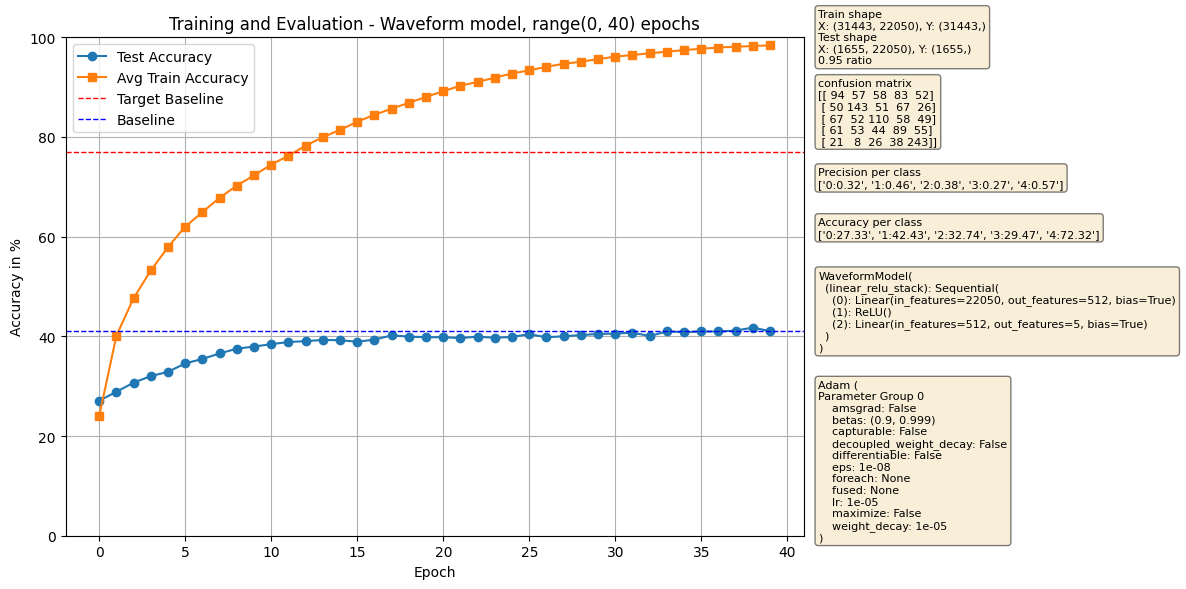

In [4]:
baseline = 0.0  
epochs = 40
target_baseline = 77.0

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


model = WaveformModel()

loss_function = nn.CrossEntropyLoss()
# weight decay / L2 regularization
optimizer = optim.Adam(model.parameters(), lr = 0.00001, weight_decay=1e-5)



for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= target_baseline:
        break

print("Done!")

plot_results(model, test_acc_arr, avg_train_acc_arr, cm,
              epochs, target_baseline, baseline,
                "Waveform", precision_per_class, acc_per_class)


# Fourier Transform

In [5]:
with open(f"{training_data}/ft.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/ft_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), y.min())

# loging, normalizing
ft = np.log1p(X)
ft_mean = np.mean(ft, axis=(0, 1), keepdims=True)
ft_std = np.std(ft, axis=(0, 1), keepdims=True)
X = (ft - ft_mean) / (ft_std + 1e-8)

with open(f"{training_data}/ft_mean.npy", "wb") as f:
        np.save(f, ft_mean)

with open(f"{training_data}/ft_std.npy", "wb") as f:
        np.save(f, ft_std)

# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 1025, 87)
Labels shape: (33098,)
886.8496 0
New min/max: 9.880836 -0.7962186


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class FourierTransformDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = FourierTransformDataset(X_train, y_train)
test_ds = FourierTransformDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class FourierTransformModel(nn.Module):
    def __init__(self):
        super(FourierTransformModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1025 * 87, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = FourierTransformModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

(31443, 1025, 87) (1655, 1025, 87) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 63.1%, Avg loss: 0.930559

Confusion Matrix:
[[137  22 135  40  10]
 [  9 254  49  21   4]
 [ 17  30 245  35   9]
 [ 18  57  76 133  18]
 [  4   3  45   9 275]]

Per-class accuracy:
Class 0: 39.83%
Class 1: 75.37%
Class 2: 72.92%
Class 3: 44.04%
Class 4: 81.85%

Per-class precision:
Class 0: 74.05%
Class 1: 69.40%
Class 2: 44.55%
Class 3: 55.88%
Class 4: 87.03%
Train Accuracy: 55.76% - Loss: 1.1901
Accuracy gain from baseline: 63.08%

Epoch 2
----------
Test error:
 Accuracy: 68.3%, Avg loss: 0.831369

Confusion Matrix:
[[214  42  50  30   8]
 [ 15 290  11  17   4]
 [ 48  59 187  35   7]
 [ 22  78  39 151  12]
 [  5   3  29  11 288]]

Per-class accuracy:
Class 0: 62.21%
Class 1: 86.05%
Class 2: 55.65%
Class 3: 50.00%
Class 4: 85.71%

Per-class precision:
Class 0: 70.39%
Class 1: 61.44%
Class 2: 59.18%
Class 3: 61.89%
Class 4: 90.28%
Train Accuracy: 68.09% - Loss: 0.8402
Accuracy gain from baseline: 5.20%

Epoch 3
----------
Test error:
 Accurac

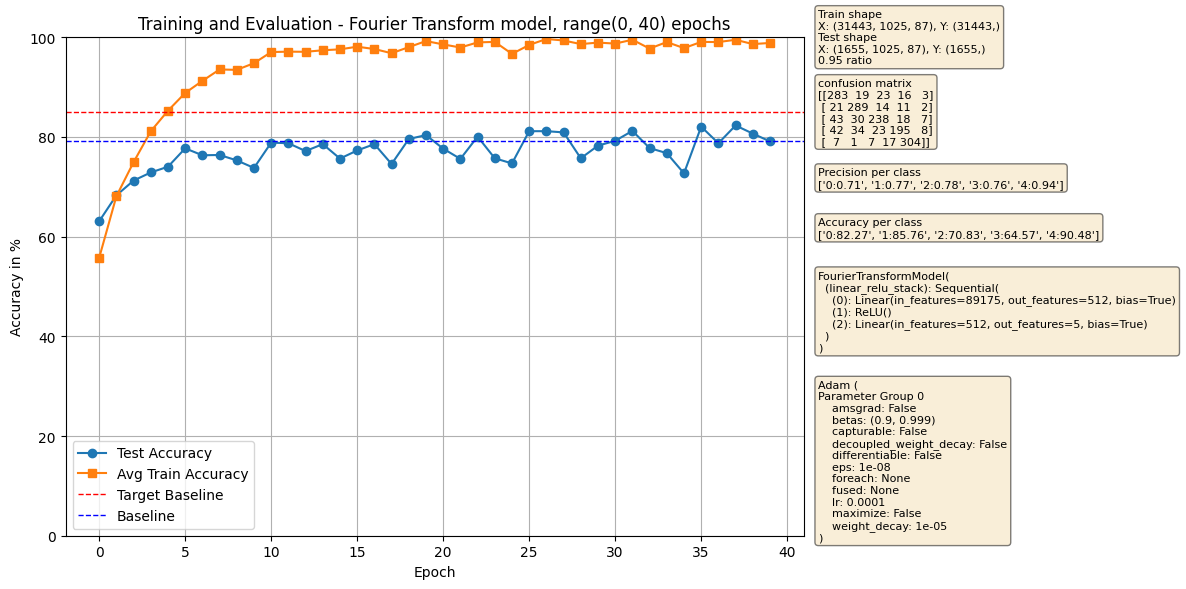

In [7]:
baseline = 0.0
target_baseline = 85.0
epochs = 40

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, per_class_accuracy, per_class_precision = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= 85.0:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm,
              epochs, target_baseline, baseline, "Fourier Transform",
              per_class_accuracy, per_class_precision)


# Spectrogram

In [8]:
with open(f"{training_data}/spectrogram.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/spectrogram_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), X.min())


if X.max() != 1.0 and y.min() != 0.0:
    print("Data needs normalization!!!!")

# loging, normalizing
# ft = np.log1p(X)
mean = np.mean(X, axis=(0, 1), keepdims=True)
std = np.std(X, axis=(0, 1), keepdims=True)
X = (X - mean) / (std)


# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 1025, 87)
Labels shape: (33098,)
3.8146973e-06 -80.0
New min/max: 2.960369 -2.0571823


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class SpectrogramDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = SpectrogramDataset(X_train, y_train)
test_ds = SpectrogramDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class SpectrogramModel(nn.Module):
    def __init__(self):
        super(SpectrogramModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1025 * 87, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = SpectrogramModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

(31443, 1025, 87) (1655, 1025, 87) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 49.6%, Avg loss: 1.355929

Confusion Matrix:
[[233   3  20  88   0]
 [ 68 134   7 128   0]
 [146  15  46 126   3]
 [ 67  15   5 213   2]
 [ 69   1   0  71 195]]

Per-class accuracy:
Class 0: 67.73%
Class 1: 39.76%
Class 2: 13.69%
Class 3: 70.53%
Class 4: 58.04%

Per-class precision:
Class 0: 39.97%
Class 1: 79.76%
Class 2: 58.97%
Class 3: 34.03%
Class 4: 97.50%
Train Accuracy: 51.55% - Loss: 1.3053
Accuracy gain from baseline: 49.61%

Epoch 2
----------
Test error:
 Accuracy: 64.3%, Avg loss: 0.929601

Confusion Matrix:
[[240  14  46  39   5]
 [ 36 215  24  62   0]
 [ 91  17 150  74   4]
 [ 48  30  31 188   5]
 [ 14   5  16  30 271]]

Per-class accuracy:
Class 0: 69.77%
Class 1: 63.80%
Class 2: 44.64%
Class 3: 62.25%
Class 4: 80.65%

Per-class precision:
Class 0: 55.94%
Class 1: 76.51%
Class 2: 56.18%
Class 3: 47.84%
Class 4: 95.09%
Train Accuracy: 64.27% - Loss: 0.9190
Accuracy gain from baseline: 14.68%

Epoch 3
----------
Test error:
 Accura

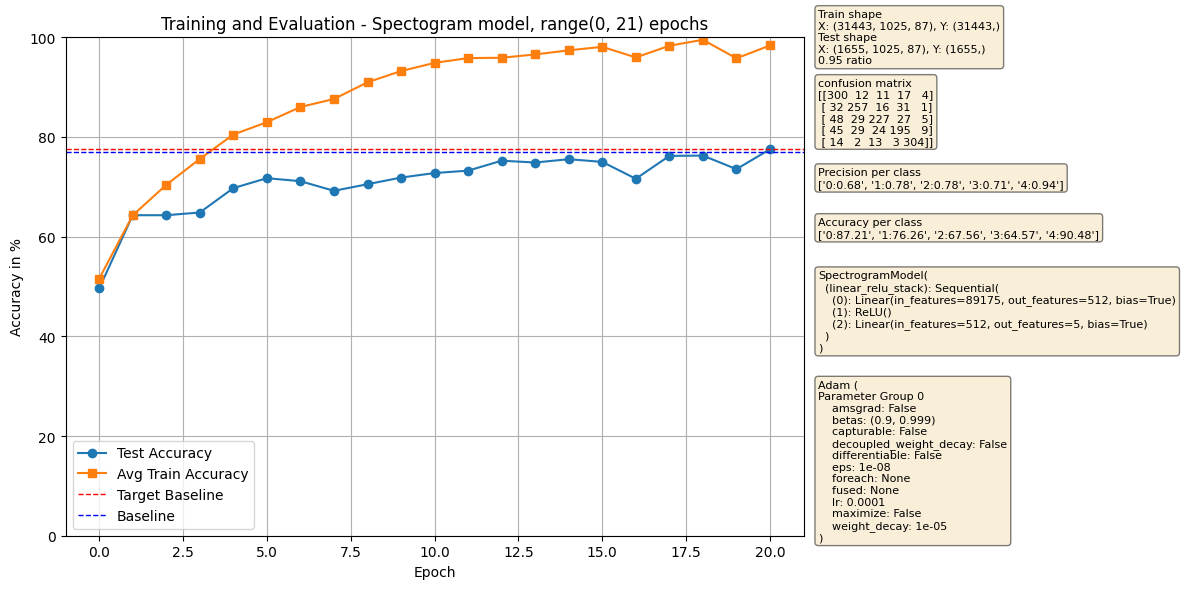

In [10]:
baseline = 0.0
target_baseline = 77.0
epochs = 40

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm,  precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= 77.0:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm, epochs, baseline, target_baseline, "Spectogram",  precision_per_class, acc_per_class)

# Mel Spectrogram

In [13]:
with open(f"{training_data}/mel_spectrogram.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/mel_spectrogram_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), X.min())


if X.max() != 1.0 and y.min() != 0.0:
    print("Data needs normalization!!!!")

# loging, normalizing
# ft = np.log1p(X)
mean = np.mean(X, axis=(0, 1), keepdims=True)
print(mean)
std = np.std(X, axis=(0, 1), keepdims=True)
print(std)

X = (X - mean) / (std)


# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 1025, 87)
Labels shape: (33098,)
0.0 -80.0
[[[-40.323593 -39.836254 -39.443424 -39.137466 -38.931488 -38.792316
   -38.628452 -38.56162  -38.572773 -38.603436 -38.646744 -38.692707
   -38.730396 -38.75276  -38.747036 -38.720978 -38.68688  -38.656246
   -38.62164  -38.601208 -38.583508 -38.564747 -38.552864 -38.539146
   -38.526203 -38.514893 -38.504654 -38.493073 -38.482937 -38.477272
   -38.471367 -38.463867 -38.45585  -38.44605  -38.4359   -38.429028
   -38.42257  -38.4181   -38.409904 -38.401554 -38.393253 -38.386665
   -38.379635 -38.372643 -38.36916  -38.367184 -38.367626 -38.37
   -38.37393  -38.376938 -38.381702 -38.384132 -38.387142 -38.39069
   -38.39649  -38.40396  -38.411976 -38.41878  -38.42612  -38.434372
   -38.445164 -38.46127  -38.481293 -38.499557 -38.52344  -38.55028
   -38.5832   -38.61188  -38.6482   -38.680878 -38.711723 -38.748238
   -38.785633 -38.807045 -38.809574 -38.800304 -38.783855 -38.771038
   -38.767437 -38.801098 -38.90271  -39.066

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class MelSpectogramDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = MelSpectogramDataset(X_train, y_train)
test_ds = MelSpectogramDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class MelSpectogramModel(nn.Module):
    def __init__(self):
        super(MelSpectogramModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1025 * 87, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = MelSpectogramModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

(31443, 1025, 87) (1655, 1025, 87) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 62.5%, Avg loss: 0.931441

Confusion Matrix:
[[229  17   6  86   6]
 [ 54 189   9  83   2]
 [103  37  89  91  16]
 [ 25  22   6 238  11]
 [  7   3   7  30 289]]

Per-class accuracy:
Class 0: 66.57%
Class 1: 56.08%
Class 2: 26.49%
Class 3: 78.81%
Class 4: 86.01%

Per-class precision:
Class 0: 54.78%
Class 1: 70.52%
Class 2: 76.07%
Class 3: 45.08%
Class 4: 89.20%
Train Accuracy: 54.99% - Loss: 1.2146
Accuracy gain from baseline: 62.48%

Epoch 2
----------
Test error:
 Accuracy: 66.8%, Avg loss: 0.885787

Confusion Matrix:
[[257  25  11  46   5]
 [ 41 234  14  48   0]
 [102  45 126  60   3]
 [ 41  32  12 210   7]
 [ 16   4  22  16 278]]

Per-class accuracy:
Class 0: 74.71%
Class 1: 69.44%
Class 2: 37.50%
Class 3: 69.54%
Class 4: 82.74%

Per-class precision:
Class 0: 56.24%
Class 1: 68.82%
Class 2: 68.11%
Class 3: 55.26%
Class 4: 94.88%
Train Accuracy: 66.14% - Loss: 0.8809
Accuracy gain from baseline: 4.29%

Epoch 3
----------
Test error:
 Accurac

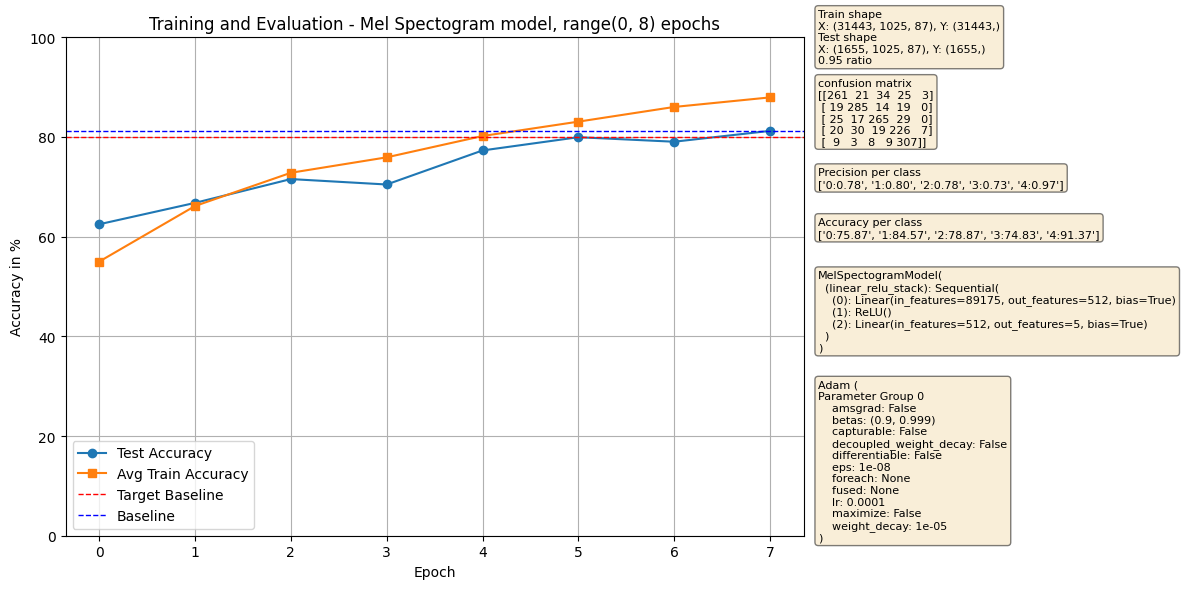

In [15]:
baseline = 0.0
target_baseline = 80.0
epochs = 40

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= target_baseline:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm, epochs, target_baseline, baseline, "Mel Spectogram", precision_per_class, acc_per_class)


# Power Spectrogram

In [16]:
with open(f"{training_data}/power_spectrogram.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/power_spectrogram_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), X.min())


if X.max() != 1.0 and y.min() != 0.0:
    print("Data needs normalization!!!!")

# loging, normalizing
# ft = np.log1p(X)
mean = np.mean(X, axis=(0, 1), keepdims=True)
std = np.std(X, axis=(0, 1), keepdims=True)
X = (X - mean) / (std)


# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 1025, 87)
Labels shape: (33098,)
0.0 -80.0
New min/max: 2.960369 -2.0571823


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class PowerSpectogramDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = PowerSpectogramDataset(X_train, y_train)
test_ds = PowerSpectogramDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class PowerSpectogramModel(nn.Module):
    def __init__(self):
        super(PowerSpectogramModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1025 * 87, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = PowerSpectogramModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

(31443, 1025, 87) (1655, 1025, 87) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 55.2%, Avg loss: 1.111847

Confusion Matrix:
[[278  18  16  31   1]
 [ 75 191  12  57   2]
 [167  37  63  65   4]
 [112  26  15 141   8]
 [ 23   4  25  44 240]]

Per-class accuracy:
Class 0: 80.81%
Class 1: 56.68%
Class 2: 18.75%
Class 3: 46.69%
Class 4: 71.43%

Per-class precision:
Class 0: 42.44%
Class 1: 69.20%
Class 2: 48.09%
Class 3: 41.72%
Class 4: 94.12%
Train Accuracy: 52.00% - Loss: 1.2922
Accuracy gain from baseline: 55.17%

Epoch 2
----------
Test error:
 Accuracy: 63.4%, Avg loss: 0.925889

Confusion Matrix:
[[241  27  28  37  11]
 [ 39 218  22  53   5]
 [ 86  36 112  73  29]
 [ 40  37  24 180  21]
 [ 10   2   7  18 299]]

Per-class accuracy:
Class 0: 70.06%
Class 1: 64.69%
Class 2: 33.33%
Class 3: 59.60%
Class 4: 88.99%

Per-class precision:
Class 0: 57.93%
Class 1: 68.12%
Class 2: 58.03%
Class 3: 49.86%
Class 4: 81.92%
Train Accuracy: 64.05% - Loss: 0.9199
Accuracy gain from baseline: 8.28%

Epoch 3
----------
Test error:
 Accurac

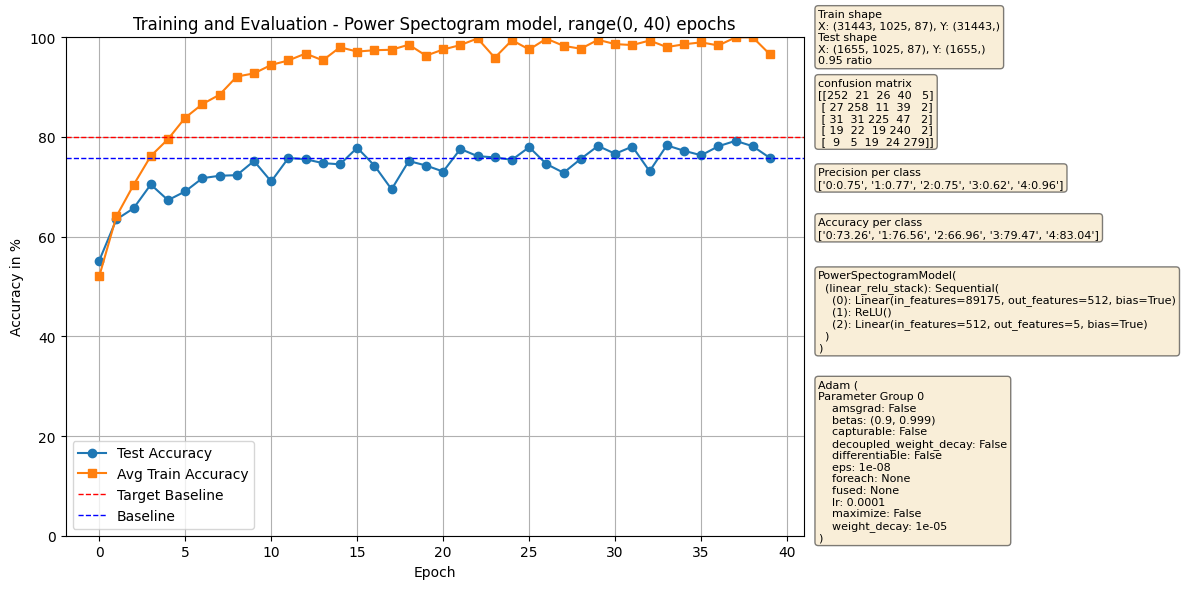

In [18]:
baseline = 0.0
target_baseline = 80.0
epochs = 40

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= target_baseline:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm, epochs, target_baseline, baseline, "Power Spectogram", precision_per_class, acc_per_class)


# MFCC

In [19]:
with open(f"{training_data}/mfcc.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/mfcc_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), X.min())


if X.max() != 1.0 and y.min() != 0.0:
    print("Data needs normalization!!!!")

# loging, normalizing
# ft = np.log1p(X)
mean = np.mean(X, axis=(0, 1), keepdims=True)
print(mean)
std = np.std(X, axis=(0, 1), keepdims=True)
print(std)

X = (X - mean) / (std)


# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 12, 87)
Labels shape: (33098,)
300.78296 -993.9934
[[[-0.51924837  0.9710556   1.155682    0.6983017   0.58937216
    0.73480844  0.86854947  0.98514616  1.0895356   1.185212
    1.26824     1.3378147   1.3928748   1.4417069   1.491781
    1.5410377   1.5875717   1.6367459   1.682452    1.7201052
    1.7533284   1.7856264   1.8238319   1.8628306   1.8962041
    1.917808    1.9317969   1.9505908   1.9671123   1.9841605
    2.006128    2.022916    2.036256    2.0497575   2.0587103
    2.0632844   2.0602045   2.0594432   2.0639184   2.0623434
    2.06495     2.0771492   2.098184    2.1166961   2.1232853
    2.123271    2.1194797   2.1092865   2.1030667   2.1005392
    2.0935528   2.0862448   2.0802052   2.0712397   2.0558631
    2.0308158   2.0025594   1.9809724   1.9630116   1.9461224
    1.9359547   1.9207214   1.8959504   1.8666266   1.8366675
    1.8116001   1.7867467   1.7561226   1.7119877   1.6589612
    1.6088209   1.5573899   1.5047227   1.4542814   1.39675

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class MFCCDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = MFCCDataset(X_train, y_train)
test_ds = MFCCDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class MFCCModel(nn.Module):
    def __init__(self):
        super(MFCCModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12*87, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = MFCCModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

(31443, 12, 87) (1655, 12, 87) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 52.5%, Avg loss: 1.174700

Confusion Matrix:
[[167  36  80  29  32]
 [ 31 209  46  41  10]
 [ 65  66 134  36  35]
 [ 50  58  82  84  28]
 [  2   1  44  14 275]]

Per-class accuracy:
Class 0: 48.55%
Class 1: 62.02%
Class 2: 39.88%
Class 3: 27.81%
Class 4: 81.85%

Per-class precision:
Class 0: 53.02%
Class 1: 56.49%
Class 2: 34.72%
Class 3: 41.18%
Class 4: 72.37%
Train Accuracy: 47.25% - Loss: 1.2502
Accuracy gain from baseline: 52.51%

Epoch 2
----------
Test error:
 Accuracy: 55.3%, Avg loss: 1.113468

Confusion Matrix:
[[144  39  68  52  41]
 [ 20 214  25  66  12]
 [ 43  54 132  64  43]
 [ 29  54  57 130  32]
 [  2   0  22  17 295]]

Per-class accuracy:
Class 0: 41.86%
Class 1: 63.50%
Class 2: 39.29%
Class 3: 43.05%
Class 4: 87.80%

Per-class precision:
Class 0: 60.50%
Class 1: 59.28%
Class 2: 43.42%
Class 3: 39.51%
Class 4: 69.74%
Train Accuracy: 52.66% - Loss: 1.1495
Accuracy gain from baseline: 2.78%

Epoch 3
----------
Test error:
 Accurac

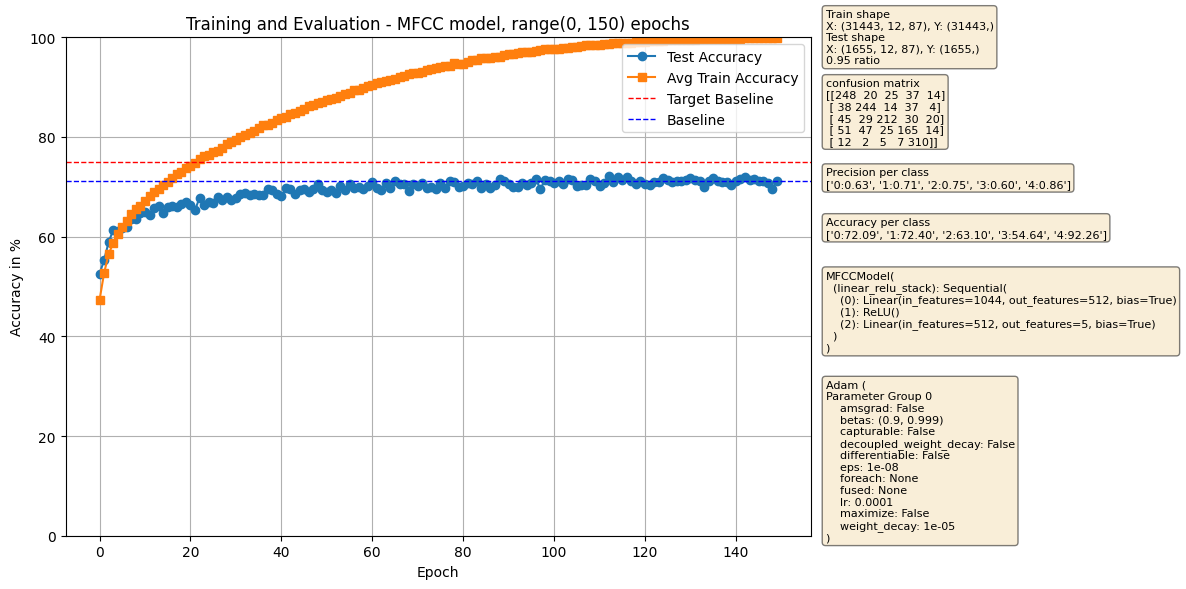

In [21]:
baseline = 0.0
target_baseline = 75.0
epochs = 150

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= target_baseline:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm, epochs, target_baseline, baseline, "MFCC", precision_per_class, acc_per_class)


# Chroma Features (STFT)

In [22]:
with open(f"{training_data}/chroma_stft.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/chroma_stft_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), X.min())


if X.max() != 1.0 and y.min() != 0.0:
    print("Data needs normalization!!!!")

# loging, normalizing
# ft = np.log1p(X)
mean = np.mean(X, axis=(0, 1), keepdims=True)
print(mean)
std = np.std(X, axis=(0, 1), keepdims=True)
print(std)

X = (X - mean) / (std)


# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 12, 87)
Labels shape: (33098,)
1.0 0.0
[[[0.44162494 0.4095588  0.38787705 0.37765867 0.37621698 0.37635386
   0.37672976 0.37666735 0.37621593 0.3759073  0.37546965 0.37569293
   0.37603486 0.37618044 0.37626535 0.37631708 0.37595195 0.3758691
   0.37617406 0.3758886  0.37607852 0.37634945 0.37640268 0.37643054
   0.37647006 0.3763214  0.37606022 0.37552288 0.3756076  0.37583107
   0.37582445 0.37587082 0.37608016 0.3755175  0.3751604  0.37474903
   0.37448862 0.37446654 0.37460515 0.37489098 0.37511587 0.37509134
   0.37553602 0.3760975  0.37604028 0.3755802  0.37513733 0.3753713
   0.3753934  0.3757482  0.37590566 0.37550178 0.37532806 0.3749759
   0.37511772 0.37558138 0.37593147 0.37621027 0.3764024  0.37622145
   0.37622595 0.37648347 0.3762195  0.37643218 0.37680867 0.37687054
   0.37677288 0.37671304 0.37636256 0.376153   0.37566686 0.37557593
   0.37569305 0.3760752  0.376057   0.37616038 0.37580347 0.37545553
   0.3749963  0.37466085 0.3748105  0.375050

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class ChromaStftDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = ChromaStftDataset(X_train, y_train)
test_ds = ChromaStftDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class ChromaStftModel(nn.Module):
    def __init__(self):
        super(ChromaStftModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12*87, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = ChromaStftModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

(31443, 12, 87) (1655, 12, 87) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 44.4%, Avg loss: 1.349561

Confusion Matrix:
[[ 97  96  61  53  37]
 [ 41 204  39  35  18]
 [ 58  78 115  38  47]
 [ 53  85  39  69  56]
 [ 13  14  22  38 249]]

Per-class accuracy:
Class 0: 28.20%
Class 1: 60.53%
Class 2: 34.23%
Class 3: 22.85%
Class 4: 74.11%

Per-class precision:
Class 0: 37.02%
Class 1: 42.77%
Class 2: 41.67%
Class 3: 29.61%
Class 4: 61.18%
Train Accuracy: 41.32% - Loss: 1.3718
Accuracy gain from baseline: 44.35%

Epoch 2
----------
Test error:
 Accuracy: 45.5%, Avg loss: 1.328520

Confusion Matrix:
[[ 93  80  64  65  42]
 [ 44 205  40  33  15]
 [ 60  66 121  42  47]
 [ 51  66  45  75  65]
 [ 17  16  25  19 259]]

Per-class accuracy:
Class 0: 27.03%
Class 1: 60.83%
Class 2: 36.01%
Class 3: 24.83%
Class 4: 77.08%

Per-class precision:
Class 0: 35.09%
Class 1: 47.34%
Class 2: 41.02%
Class 3: 32.05%
Class 4: 60.51%
Train Accuracy: 46.97% - Loss: 1.2871
Accuracy gain from baseline: 1.15%

Epoch 3
----------
Test error:
 Accurac

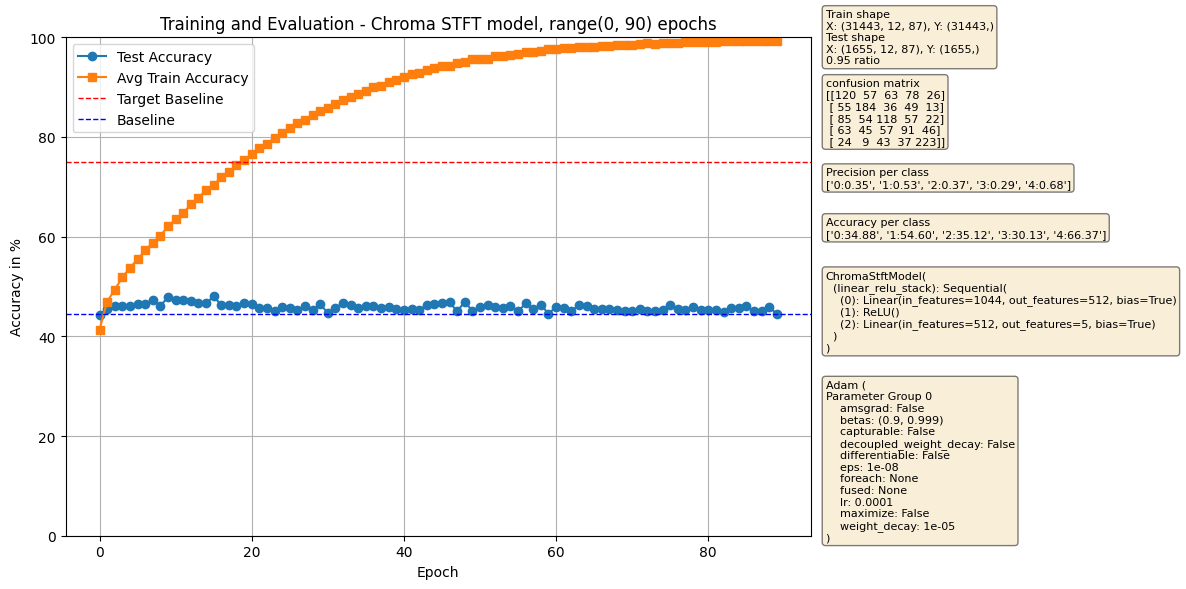

In [24]:
baseline = 0.0
target_baseline = 75.0
epochs = 90

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= target_baseline:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm, epochs, target_baseline, baseline, "Chroma STFT", precision_per_class, acc_per_class)


# Chroma Features (CQT)

In [25]:
with open(f"{training_data}/chroma_cqt.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/chroma_cqt_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), X.min())


if X.max() != 1.0 and y.min() != 0.0:
    print("Data needs normalization!!!!")

# loging, normalizing
# ft = np.log1p(X)
mean = np.mean(X, axis=(0, 1), keepdims=True)
print(mean)
std = np.std(X, axis=(0, 1), keepdims=True)
print(std)

X = (X - mean) / (std)


# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 12, 44)
Labels shape: (33098,)
1.0 0.000119608376
[[[0.5072567  0.47849408 0.46494973 0.4586848  0.4553525  0.45329958
   0.4523205  0.45143497 0.4509016  0.45010507 0.44954774 0.44925952
   0.4490687  0.44883314 0.44842097 0.44852078 0.44854897 0.44838402
   0.44821337 0.44832575 0.4484322  0.44865802 0.44855362 0.44859993
   0.44808024 0.44828516 0.4483251  0.44840363 0.4487087  0.4492147
   0.44909778 0.44909856 0.44894072 0.44899088 0.4489709  0.4492243
   0.4497752  0.45023578 0.4514262  0.4528268  0.45546943 0.46070877
   0.47239083 0.50055337]]]
[[[0.25492272 0.26771182 0.2740314  0.27696165 0.27845356 0.27954638
   0.2803873  0.28049377 0.28083098 0.28098035 0.28074175 0.28068146
   0.2807958  0.2810281  0.28095564 0.28115323 0.28114974 0.28109583
   0.281179   0.28125122 0.2814736  0.28157222 0.28132454 0.28139475
   0.2813148  0.2814551  0.28157216 0.2817361  0.28169048 0.28173146
   0.281678   0.2816314  0.28127825 0.2810857  0.28093997 0.2811017
   0.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class ChromaCqtDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = ChromaCqtDataset(X_train, y_train)
test_ds = ChromaCqtDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class ChromaCqtModel(nn.Module):
    def __init__(self):
        super(ChromaCqtModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12*44, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = ChromaCqtModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

(31443, 12, 44) (1655, 12, 44) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 41.6%, Avg loss: 1.377988

Confusion Matrix:
[[112  69  59  52  52]
 [ 63 168  38  31  37]
 [ 71  73  89  47  56]
 [ 60  71  26  57  88]
 [ 14  17  16  26 263]]

Per-class accuracy:
Class 0: 32.56%
Class 1: 49.85%
Class 2: 26.49%
Class 3: 18.87%
Class 4: 78.27%

Per-class precision:
Class 0: 35.00%
Class 1: 42.21%
Class 2: 39.04%
Class 3: 26.76%
Class 4: 53.02%
Train Accuracy: 38.40% - Loss: 1.4247
Accuracy gain from baseline: 41.63%

Epoch 2
----------
Test error:
 Accuracy: 43.3%, Avg loss: 1.345282

Confusion Matrix:
[[ 94  77  73  58  42]
 [ 42 177  60  32  26]
 [ 50  73 114  45  54]
 [ 50  69  37  66  80]
 [ 14  12  17  27 266]]

Per-class accuracy:
Class 0: 27.33%
Class 1: 52.52%
Class 2: 33.93%
Class 3: 21.85%
Class 4: 79.17%

Per-class precision:
Class 0: 37.60%
Class 1: 43.38%
Class 2: 37.87%
Class 3: 28.95%
Class 4: 56.84%
Train Accuracy: 43.59% - Loss: 1.3400
Accuracy gain from baseline: 1.69%

Epoch 3
----------
Test error:
 Accurac

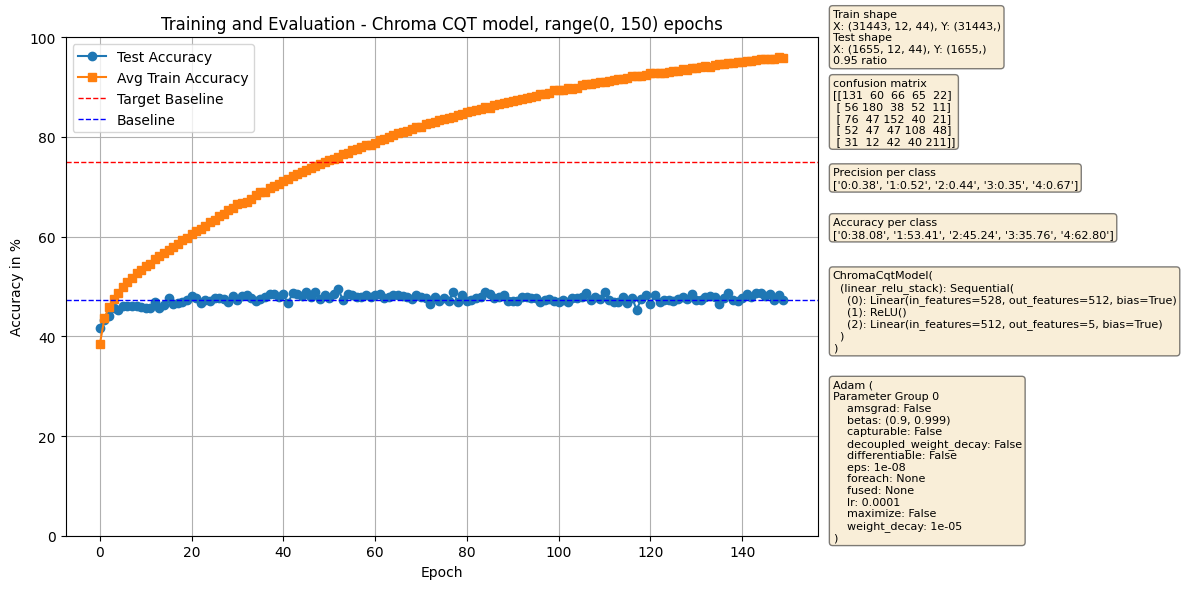

In [27]:
baseline = 0.0
target_baseline = 75.0
epochs = 150

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= target_baseline:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm, epochs, target_baseline, baseline, "Chroma CQT", precision_per_class, acc_per_class)


# Chroma Features (CENS)

In [28]:
with open(f"{training_data}/chroma_cens.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/chroma_cens_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), X.min())


if X.max() != 1.0 and y.min() != 0.0:
    print("Data needs normalization!!!!")

# loging, normalizing
# ft = np.log1p(X)
mean = np.mean(X, axis=(0, 1), keepdims=True)
print(mean)
std = np.std(X, axis=(0, 1), keepdims=True)
print(std)

X = (X - mean) / (std)


# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 12, 44)
Labels shape: (33098,)
0.99999714 0.0
[[[0.242802   0.24285418 0.24292934 0.24302597 0.2431427  0.24321325
   0.24327227 0.2433457  0.24341175 0.24348426 0.24355415 0.24358027
   0.24360473 0.24357682 0.24357246 0.24354975 0.24349557 0.24345317
   0.24338374 0.24332038 0.24326727 0.24322882 0.2432141  0.24320856
   0.24322547 0.2432456  0.24326842 0.24327582 0.24329276 0.24326977
   0.24323556 0.24322405 0.24315608 0.24308957 0.24298416 0.24286905
   0.24276046 0.24264304 0.24254453 0.24242598 0.24226205 0.24211504
   0.24198788 0.24187854]]]
[[[0.1561323  0.15601705 0.15588596 0.15575226 0.15564418 0.15551175
   0.15538225 0.15526776 0.15515701 0.15506157 0.1549854  0.15494306
   0.15491118 0.15490149 0.15491723 0.15494429 0.1550127  0.15509473
   0.155196   0.15530103 0.1553877  0.155453   0.15548456 0.15548249
   0.15544869 0.1554148  0.15537906 0.1553634  0.15536092 0.15537912
   0.15543197 0.15550005 0.15559964 0.1557183  0.15583676 0.155994
   0.156

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class ChromaCensDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = ChromaCensDataset(X_train, y_train)
test_ds = ChromaCensDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class ChromaCensModel(nn.Module):
    def __init__(self):
        super(ChromaCensModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12*44, 512),
            nn.ReLU(),
            # nn.Linear(2048, 128),
            # nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = ChromaCensModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

(31443, 12, 44) (1655, 12, 44) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 42.6%, Avg loss: 1.352124

Confusion Matrix:
[[121  86  51  47  39]
 [ 47 198  44  25  23]
 [ 75  96  78  36  51]
 [ 64  85  22  67  64]
 [ 22  23  15  35 241]]

Per-class accuracy:
Class 0: 35.17%
Class 1: 58.75%
Class 2: 23.21%
Class 3: 22.19%
Class 4: 71.73%

Per-class precision:
Class 0: 36.78%
Class 1: 40.57%
Class 2: 37.14%
Class 3: 31.90%
Class 4: 57.66%
Train Accuracy: 39.22% - Loss: 1.4050
Accuracy gain from baseline: 42.60%

Epoch 2
----------
Test error:
 Accuracy: 43.0%, Avg loss: 1.331525

Confusion Matrix:
[[114  72  74  45  39]
 [ 50 185  54  28  20]
 [ 87  70  99  40  40]
 [ 53  76  37  69  67]
 [ 21  15  27  29 244]]

Per-class accuracy:
Class 0: 33.14%
Class 1: 54.90%
Class 2: 29.46%
Class 3: 22.85%
Class 4: 72.62%

Per-class precision:
Class 0: 35.08%
Class 1: 44.26%
Class 2: 34.02%
Class 3: 32.70%
Class 4: 59.51%
Train Accuracy: 42.86% - Loss: 1.3378
Accuracy gain from baseline: 0.36%

Epoch 3
----------
Test error:
 Accurac

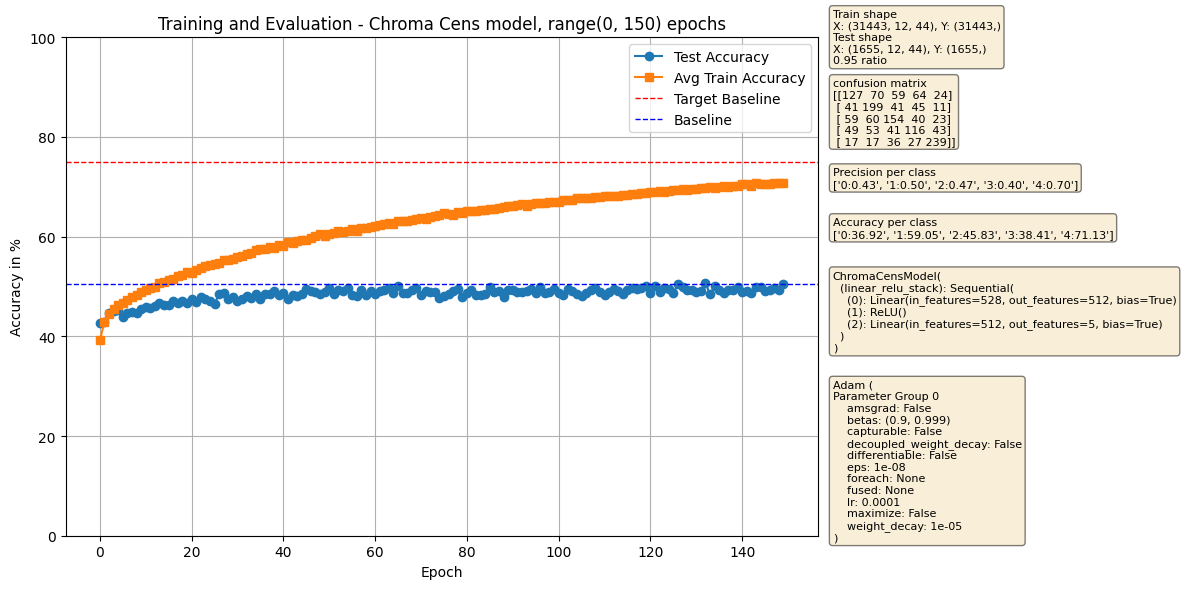

In [30]:
baseline = 0.0
target_baseline = 75.0
epochs = 150

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= target_baseline:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm, epochs, target_baseline, baseline, "Chroma Cens", precision_per_class, acc_per_class)


# Tonnetz

In [31]:
with open(f"{training_data}/tonnetz.npy", "rb") as f:
    X = np.load(f)

with open(f"{training_data}/tonnetz_labels.npy", "rb") as f:
    y = np.load(f)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

print(X.max(), X.min())


if X.max() != 1.0 and y.min() != 0.0:
    print("Data needs normalization!!!!")

# loging, normalizing
# ft = np.log1p(X)
mean = np.mean(X, axis=(0, 1), keepdims=True)
print(mean)
std = np.std(X, axis=(0, 1), keepdims=True)
print(std)

X = (X - mean) / (std)


# TODO save the mean and std for sample processing

print("New min/max:", X.max(), X.min())

Dataset shape: (33098, 6, 44)
Labels shape: (33098,)
0.9343706 -0.90477926
[[[0.00455296 0.00619414 0.00725781 0.00790069 0.00833135 0.00864511
   0.00889849 0.00900202 0.00909988 0.00908753 0.00911568 0.00923774
   0.00933688 0.00932626 0.00927658 0.00925419 0.00923104 0.00917598
   0.00923174 0.00924309 0.0092548  0.00923674 0.00922111 0.00922927
   0.00931828 0.00935552 0.00942221 0.00948898 0.00954437 0.00945672
   0.00939471 0.00928307 0.0093314  0.00934973 0.00937138 0.00923366
   0.00913734 0.0089563  0.00875471 0.00851813 0.0081897  0.00762035
   0.00657594 0.00486324]]]
[[[0.07424698 0.09751948 0.11012217 0.1166359  0.12031414 0.12272537
   0.12436888 0.125536   0.12646192 0.12720871 0.12758118 0.12798668
   0.12834801 0.12870868 0.12887982 0.12891744 0.12881912 0.12889622
   0.12903167 0.1290578  0.12901123 0.12887046 0.12888755 0.12888291
   0.12898304 0.12894028 0.12893037 0.12893713 0.12882324 0.1287403
   0.12879227 0.12866059 0.12838131 0.12808889 0.12777008 0.12737766
 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_test_size, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class TonnetzDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

train_ds = TonnetzDataset(X_train, y_train)
test_ds = TonnetzDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

next(iter(test_ds))


class TonnetzModel(nn.Module):
    def __init__(self):
        super(TonnetzModel, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6*44, 512),
            nn.ReLU(),
            nn.Linear(512,5),
        )

# 1025 * 87 -> 128 76%

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        logits = self.linear_relu_stack(x)
        return logits
    
model = TonnetzModel()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

(31443, 6, 44) (1655, 6, 44) (31443,) (1655,)


Epoch 1
----------
Test error:
 Accuracy: 38.4%, Avg loss: 1.439032

Confusion Matrix:
[[ 40 125  47  74  58]
 [ 29 184  55  36  33]
 [ 19 133  93  37  54]
 [ 28  62  56  64  92]
 [ 10  19  27  26 254]]

Per-class accuracy:
Class 0: 11.63%
Class 1: 54.60%
Class 2: 27.68%
Class 3: 21.19%
Class 4: 75.60%

Per-class precision:
Class 0: 31.75%
Class 1: 35.18%
Class 2: 33.45%
Class 3: 27.00%
Class 4: 51.73%
Train Accuracy: 32.57% - Loss: 1.5036
Accuracy gain from baseline: 38.37%

Epoch 2
----------
Test error:
 Accuracy: 38.5%, Avg loss: 1.415736

Confusion Matrix:
[[ 26 202  41  25  50]
 [ 14 255  20  15  33]
 [ 19 191  58  16  52]
 [ 19 117  36  37  93]
 [ 10  34  13  17 262]]

Per-class accuracy:
Class 0: 7.56%
Class 1: 75.67%
Class 2: 17.26%
Class 3: 12.25%
Class 4: 77.98%

Per-class precision:
Class 0: 29.55%
Class 1: 31.91%
Class 2: 34.52%
Class 3: 33.64%
Class 4: 53.47%
Train Accuracy: 38.05% - Loss: 1.4196
Accuracy gain from baseline: 0.18%

Epoch 3
----------
Test error:
 Accuracy

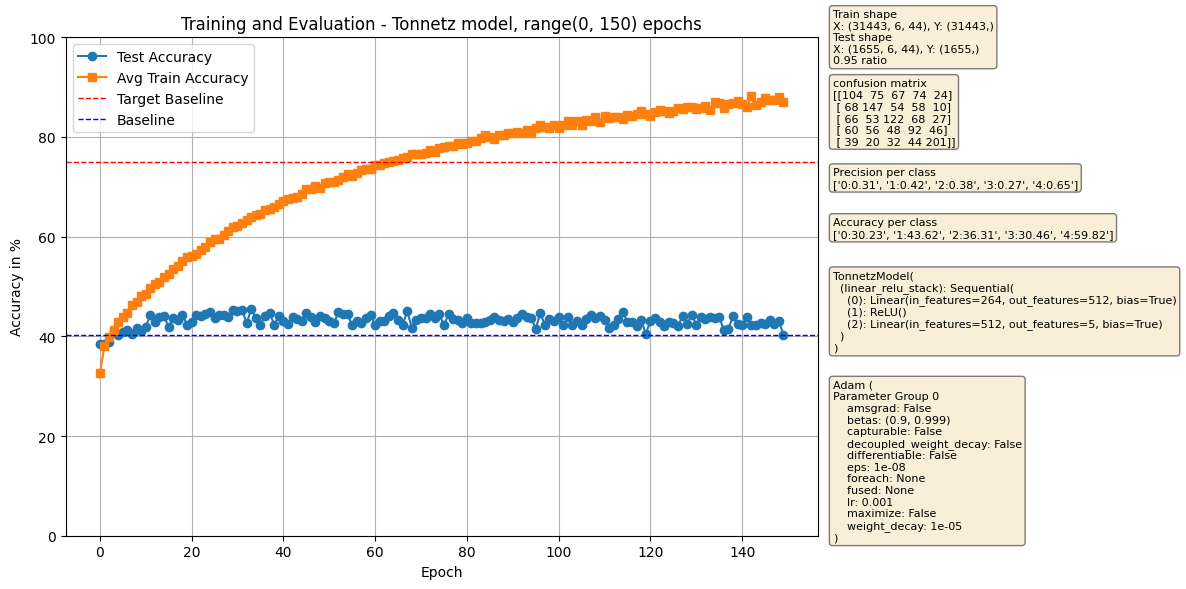

In [33]:
baseline = 0.0
target_baseline = 75.0
epochs = 150

test_acc_arr = []
avg_train_acc_arr = []
avg_train_loss_arr = []
acc_gain_arr = []
baseline_arr = []


for e in range(epochs):
    print(f"Epoch {e+1}\n{'-'*10}")

    test_acc, avg_train_acc, avg_train_loss, cm, precision_per_class, acc_per_class = train(train_loader, model, loss_function, optimizer)

    acc_gain = test_acc - baseline
    baseline = test_acc
    
    test_acc_arr.append(test_acc)
    avg_train_acc_arr.append(avg_train_acc)
    avg_train_loss_arr.append(avg_train_loss)
    acc_gain_arr.append(acc_gain)
    baseline_arr.append(baseline)


    print(f"Train Accuracy: {avg_train_acc:.2f}% - Loss: {avg_train_loss:.4f}")
    print(f"Accuracy gain from baseline: {acc_gain:.2f}%\n")
    
    if baseline >= target_baseline:
        break

print("Done!")


plot_results(model, test_acc_arr, avg_train_acc_arr, cm, epochs, target_baseline, baseline, "Tonnetz", precision_per_class, acc_per_class)
